## Stereo
Depth Map from Stereo Images

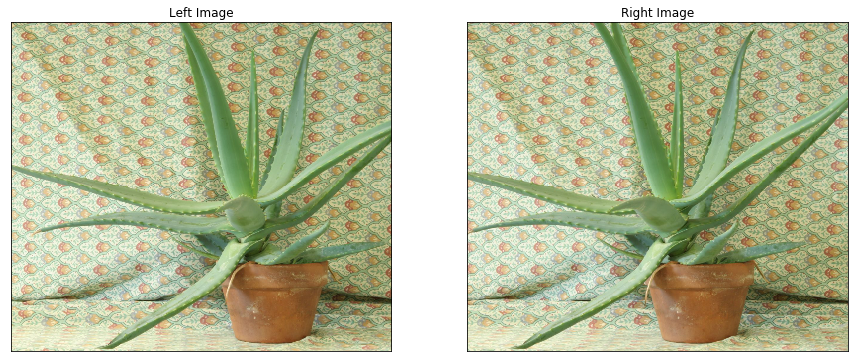

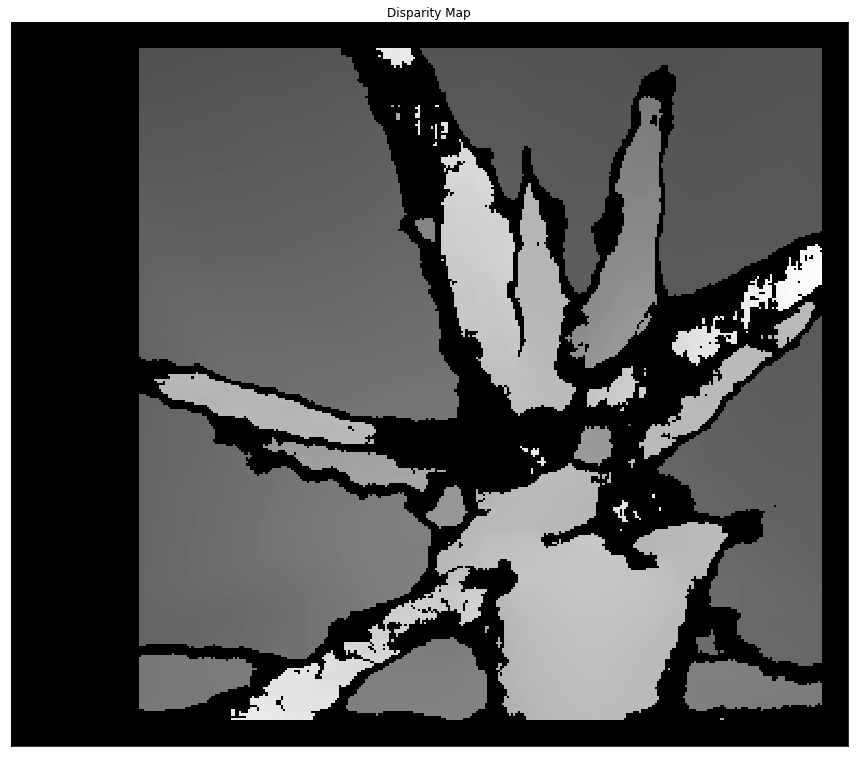

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# load left and right images
imgL = cv2.imread("/home/gary/opencv/samples/data/aloeL.jpg");
imgR = cv2.imread("/home/gary/opencv/samples/data/aloeR.jpg");

# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# convert to grayscale
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

# compute disparity map
stereo = cv2.StereoBM_create(numDisparities=16*3, blockSize=25)
disparity = stereo.compute(imgL_gray, imgR_gray)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB))
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.imshow(disparity, cmap="gray")
plt.title("Disparity Map"), plt.xticks([]), plt.yticks([])
plt.show()

##### Epipolar Geometry

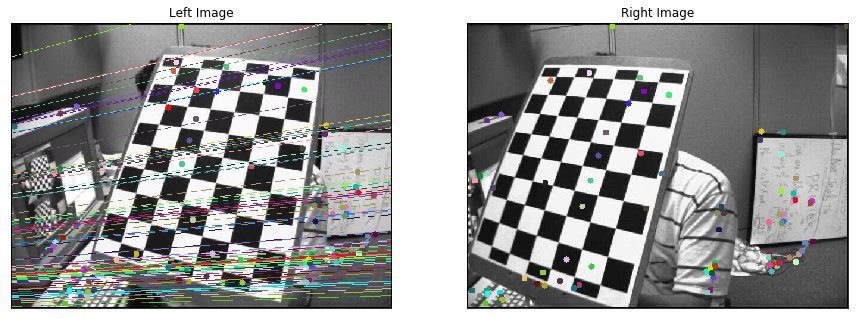

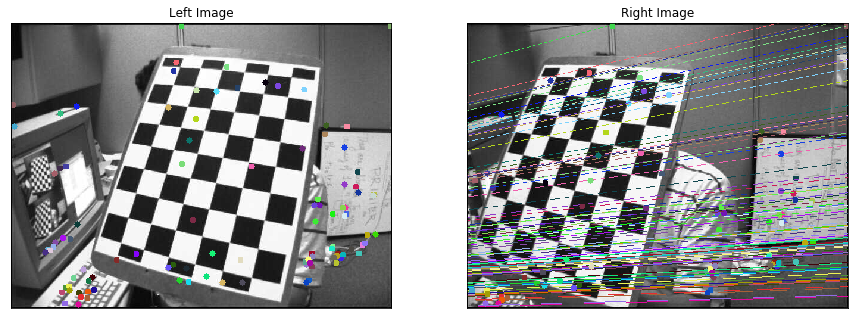

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    r, c = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

# load left and right images
imgL = cv2.imread("/home/gary/opencv/samples/data/left08.jpg",
                     cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread("/home/gary/opencv/samples/data/right08.jpg", 
                    cv2.IMREAD_GRAYSCALE)

# we need to find as many possible matches between two images to find
# the fundamental matrix
sift = cv2.xfeatures2d.SIFT_create()
# create a Brute-Force Matcher
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptors with SIFT
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(desL, desR, k=2)

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1 = drawlines(imgL, imgR, linesL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 2, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

## Optical Flow
Dense Optical Flow: Computing the optical flow for all points in the frame

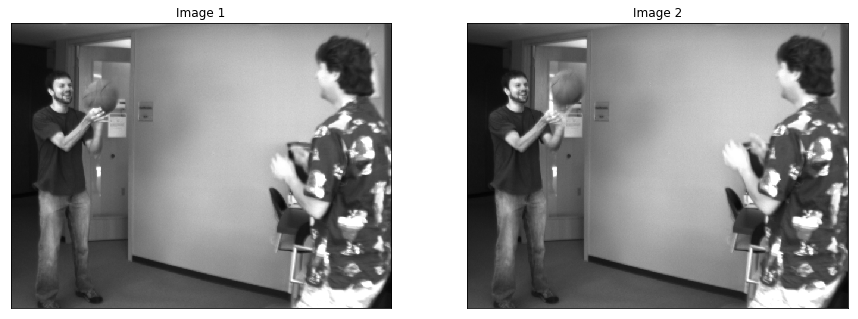

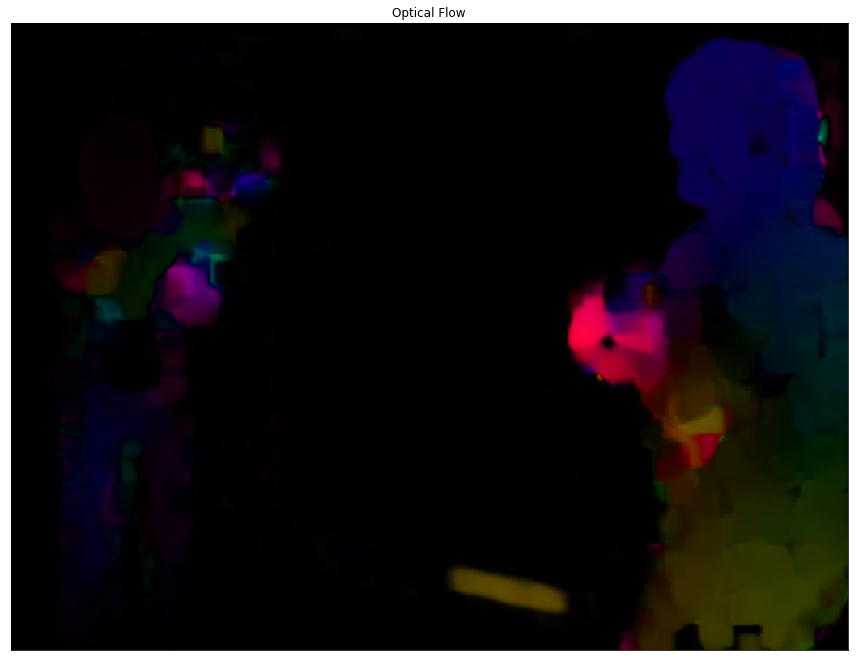

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# read images
img1 = cv2.imread("/home/gary/opencv/samples/data/basketball1.png")
img2 = cv2.imread("/home/gary/opencv/samples/data/basketball2.png")

# convert to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# To display the flow, we'll map different flow directions into different
# colors. The flow magnitude determines the color intensity. It is much
# easier to do this using the HSV color-space
# Hue: flow direcction
# Value: flow magnitude
# Saturation: constant
# initialize the hsv image
hsv = np.zeros_like(img1)
# set the saturation level
hsv[:, :, 1] = 255

# Compute optical flow using the Gunner Farneback's algorithm
# calcOpticalFlowFarneback(prev, next, pyr_scale, levels, winsize, 
#    iterations, poly_n, poly_sigma, flags)
# pyr_scale: parameter specifying the image scale (<1) to build pyramids
# levels: number of pyramid layers including the initial image
# winsize: averaging window size
# iterations: number of iterations the algorithm does at each pyramid
#   level
# poly_n: size of the pixel neighborhood used to find polynomial expansion
#   in each pixel
# poly_sigma: standard deviation of the Gaussian that is used to smooth
#   derivatives
# flags: OPTFLOW_USE_INITAL_FLOW uses the input flow as initial flow
#   approximation
# flow has the same size as prev with two channels: horizontal (0) and
#   vertial (1) flow components
flow = cv2.calcOpticalFlowFarneback(img1_gray, img2_gray, None, 0.5,
                                   3, 15, 3, 5, 1.2, 0)

# compute the mag/ang flow from the horizontal/vertial flow
mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1])

# set the hue to the angular flow (in radians)
hsv[:, :, 0] = (ang * 180 / np.pi) / 2

# set the intensity to the normalized mag flow
hsv[:, :, 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)

# convert to RGB for display
rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Image 1"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Image 2"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.imshow(rgb)
plt.title("Optical Flow"), plt.xticks([]), plt.yticks([])
plt.show()

Lucas-Kanade Optical Flow: Tracking corner-like points

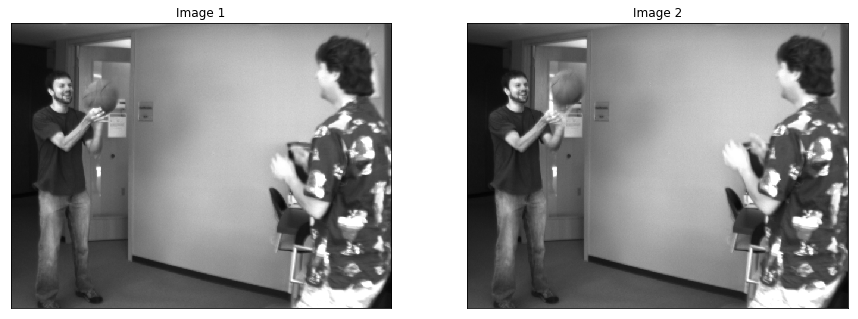

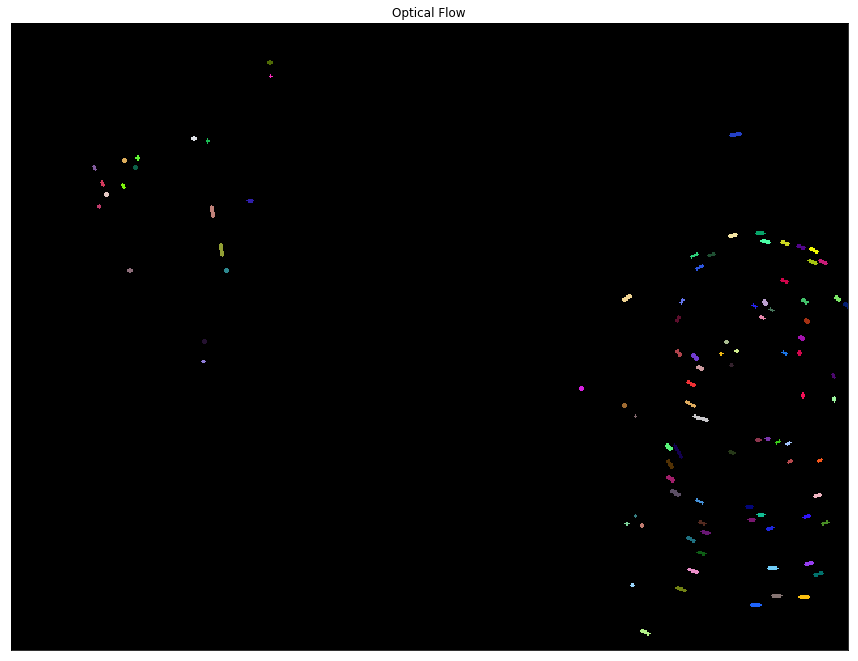

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# read images
img1 = cv2.imread("/home/gary/opencv/samples/data/basketball1.png")
img2 = cv2.imread("/home/gary/opencv/samples/data/basketball2.png")

# convert to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# parameters for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# parameters for lucas kanade optical flow
lk_params = dict( winSize = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                             10, 0.03))

# create some random colors
color = np.random.randint(0, 255, (100, 3))

# find good corners in the first image
p0 = cv2.goodFeaturesToTrack(img1_gray, **feature_params)

# create a mask image for drawing purposes
mask = np.zeros_like(img1)

# calculate optical flow
# pass the previous image, previous points and the current image
# p1: current points
# st: status numbers which has a value of 1 if next point is found,
#   else zero
p1, st, err = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, p0, None, **lk_params)

# select good points
good_new = p1[st==1]
good_old = p0[st==1]

# draw the tracks
for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel()
    c, d = old.ravel()
    mask = cv2.line(mask, (a,b), (c,d), color[i].tolist(), 2)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Image 1"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Image 2"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.imshow(mask)
plt.title("Optical Flow"), plt.xticks([]), plt.yticks([])
plt.show()